In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

#### Read a WOD nc file (produced by ODV) and smooth through years for depths less then 11 m, var1 is depth

In [2]:
ds = xr.open_dataset('wadden_sea.nc')
df = ds.to_dataframe()
df = df[(df.date_time > '2000-01-01 00:00:00.0') & (df.var1 < 11)]
df = df[['longitude', 'latitude', 'date_time'
        ,'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'
        ,'var8', 'var9', 'var10', 'var11', 'var12', 'var13', 'var14']]
df.columns = ['longitude', 'latitude', 'date_time'
             ,'Depth', 'Temperature', 'Salinity', 'Oxygen', 'Phosphate', 'Silicate', 'Nitrate'
             ,'Nitrite', 'pH', 'Chlorophyll a', 'Plankton biomass', 'Alkalinity', 'NO2+NO3', 'pCO2']
df['Oxygen'] = df['Oxygen']*44.661 # 1 ml/l = 10^3/22.391 = 44.661 μmol/l
df['Day of year'] = df.date_time.dt.dayofyear.values
dfmean = df.groupby(['Day of year']).mean()
dfmean = dfmean.reindex(index=range(1,366))

In [3]:
dfyear = df[(df.date_time > '2010-01-01 00:00:00.0') & (df.date_time < '2011-01-01 00:00:00.0')]
dfyear = dfyear.groupby(['Day of year']).mean()
dfyear = dfyear.reindex(index=range(1,366))

In [4]:
dfyear = dfyear.interpolate(method='linear',limit_direction='forward')
dfyear.loc[0:16,:] = dfyear[-1:].values
dfyear.loc[0:16,'Chlorophyll a'] = 0
dfyear = dfyear.interpolate(method='linear',limit_direction='both')
dfyear = dfyear.rolling(window=16).mean()
dfyear = dfyear.interpolate(method='linear',limit_direction='both')

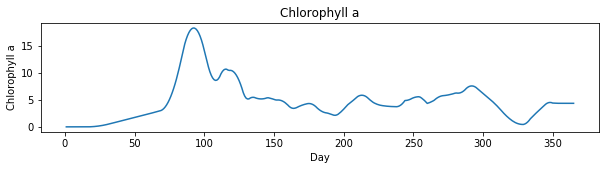

In [5]:
name = 'Chlorophyll a'
plt.plot(dfyear.index, dfyear[name]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel(name);

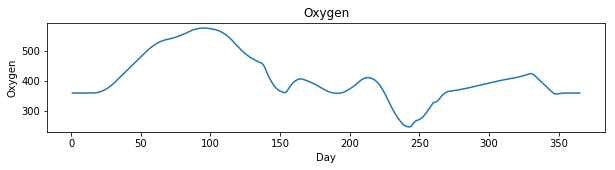

In [6]:
name = 'Oxygen'
plt.plot(dfyear.index, dfyear[name]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel(name);

In [7]:
dfmean = dfmean.interpolate(method='linear',limit_direction='forward')
dfmean.loc[0:16,:] = dfmean[-1:].values
dfmean.loc[0:16,'Chlorophyll a'] = 0
dfmean = dfmean.interpolate(method='linear',limit_direction='both')
dfmean = dfmean.rolling(window=16).mean()
dfmean = dfmean.interpolate(method='linear',limit_direction='both')

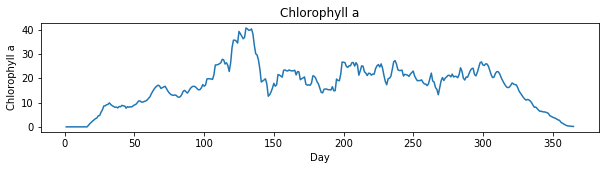

In [8]:
name = 'Chlorophyll a'
plt.plot(dfmean.index, dfmean[name]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel(name);

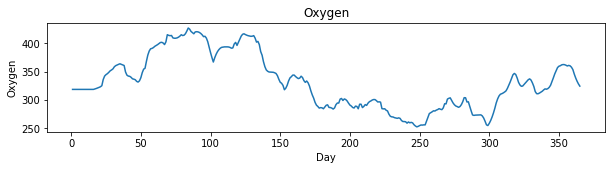

In [9]:
name = 'Oxygen'
plt.plot(dfmean.index, dfmean[name]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel(name);

#### Read and process a text file downloaded from http://tsdata.hzg.de/ (Pile Hoernum1 station)

In [10]:
dfpar = pd.read_csv('Pile_Hoernum1_PAR_20080101_20180608.dat', header=None, delim_whitespace=True
                   , skiprows=22)
dfpar[0] = dfpar[0] + ' ' + dfpar[1]
dfpar = dfpar.drop(1, axis=1)
dfpar[0] =  pd.to_datetime(dfpar[0])
dfpar = dfpar.rename(columns={0: 'date_time', 2: 'par', 3: 'flag'})
dfpar = dfpar[(dfpar['flag'] < 3) & (dfpar['par'] > 0)]
dfpar = dfpar.drop('flag', axis=1)
dfpar['Day of year'] = dfpar.date_time.dt.dayofyear.values
dfparmean = dfpar.groupby(['Day of year']).mean()
dfparmean = dfparmean.reindex(index=range(1,366))

In [11]:
dfparmean = dfparmean.interpolate(method='linear',limit_direction='both')
dfparmean = dfparmean.rolling(window=16).mean()
dfparmean = dfparmean.interpolate(method='linear',limit_direction='both')

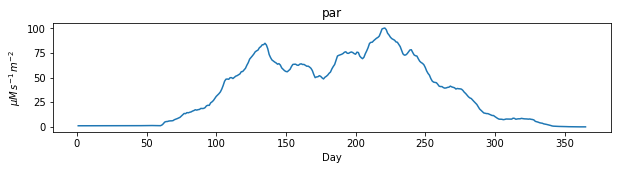

In [12]:
name = 'par'
plt.plot(dfparmean.index, dfparmean[name]);
plt.gcf().set_size_inches(10,2); plt.title(name);
plt.xlabel('Day'); plt.ylabel('$\mu M\,s^{-1}\,m^{-2}$');

#### Generate yearly DON, gpp, npp according to Beusekom (1999)

In [13]:
from scipy import integrate

The original flux of DOM is 110 $gC\,m^{-2} y^{-1}$ for the total water column, the Wadden sea has an average depth 2.5 meters, and in the model we have 2 layers 1.25 depth each, also we assume them mixed. So 110/2 for each layer.

In [14]:
annual_flux_don = ((110/2)/12.011) * 1000 * (16/106)# mM N m-2 d-1

The same for gpp, initial value is 309 $gC\,m^{-2} y^{-1}$

In [15]:
gpp = ((309/2)/12.011) * 1000 * (16/106)# mM N m-2 d-1

From Tillmann (2000) npp/gpp for this region is approximately 0.8

In [16]:
npp = 0.8 * gpp

Function for parameter 'm' identification (maximum) with given total yearly value

In [17]:
def sinusoidal(fr, ti, st, var):
    """fr - lower bound of the parameter
       ti - upper bound of the parameter
       st - step for the parameter selection
       var - the value of the assessed sinusoidal integral"""
    for m in np.arange(fr, ti, st):
        flux = lambda day: m/16 + (m/2)*(1+np.sin(2*np.pi*(day-40)/365))
        sumflux = integrate.quad(flux, 0, 365)
        if var-1 < sumflux[0] < var+1:
            print(m)

#### DON

In [18]:
sinusoidal(0,100,0.01,annual_flux_don)

3.37


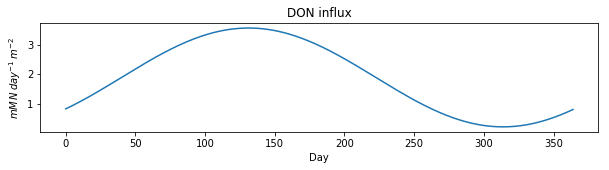

In [19]:
m = 3.37
day = np.arange(0,365,1)
y_don = m/16 + (m/2)*(1+np.sin(2*np.pi*(day-40)/365))
plt.plot(day, y_don); plt.gcf().set_size_inches(10,2);
plt.title('DON influx'); plt.xlabel('Day');
plt.ylabel('$mM\,N\,day^{-1}\,m^{-2}$');

#### GPP

In [20]:
sinusoidal(0,100,0.01,gpp)

9.46


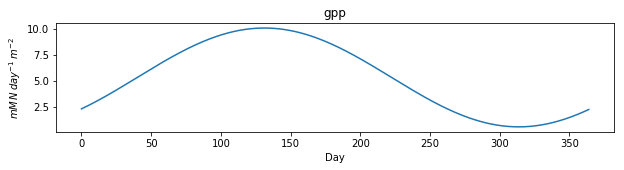

In [21]:
m = 9.47
day = np.arange(0,365,1)
y_gpp = m/16 + (m/2)*(1+np.sin(2*np.pi*(day-40)/365))
plt.plot(day, y_gpp); plt.gcf().set_size_inches(10,2);
plt.title('gpp'); plt.xlabel('Day');
plt.ylabel('$mM\,N\,day^{-1}\,m^{-2}$');

#### NPP

In [22]:
sinusoidal(0,100,0.01,npp)

7.57


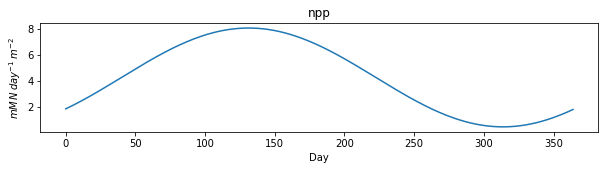

In [23]:
m = 7.57
day = np.arange(0,365,1)
y_npp = m/16 + (m/2)*(1+np.sin(2*np.pi*(day-40)/365))
plt.plot(day, y_npp); plt.gcf().set_size_inches(10,2);
plt.title('npp'); plt.xlabel('Day');
plt.ylabel('$mM\,N\,day^{-1}\,m^{-2}$');

Info: according to Kowalski (2012) peak of the algae cell carbon in the spring approx 500 $C\,\mu G\,L^{-1}$

#### Generate a wadden_sea_out.nc file

In [24]:
import utilities as ut
import itertools as it
from netCDF4 import Dataset

rootgrp = Dataset("wadden_sea_out.nc", "w", format='NETCDF3_CLASSIC')

levelface = rootgrp.createDimension("levelface", 3)
levelcntr = rootgrp.createDimension("levelcntr", 2)
time = rootgrp.createDimension("time", 365)

times = rootgrp.createVariable("time","f8",("time",))
times.units = "seconds since 2015-01-01 00:00:00.0"
times.calendar = "gregorian"

par = rootgrp.createVariable("par","f4",("time",))
par.units = "microM photons m−2 s−1"

hice = rootgrp.createVariable("hice","f4",("time",))
snowthick = rootgrp.createVariable("snowthick","f4",("time",))
icesurft = rootgrp.createVariable("icesurft","f4",("time",))

levelsface = rootgrp.createVariable("levelface","f4",("levelface",))
levelsface.units = "m"
levelscntr = rootgrp.createVariable("levelcntr","f4",("levelcntr",))
levelscntr.units = "m"
temperature = rootgrp.createVariable("temperature","f8",("time","levelcntr",))
temperature.units = "C degrees"
salinity = rootgrp.createVariable("salinity","f8",("time","levelcntr",))
salinity.units = "psu"
sigma = rootgrp.createVariable("sigma","f8",("time","levelcntr",))
sigma.units = "kg m-1"
turbulence = rootgrp.createVariable("turbulence","f8",("time","levelface",))
turbulence.units = "m2 s-1"

nitrate = rootgrp.createVariable("nitrate","f8",("time","levelcntr",))
nitrate.units = "mM N m-3"
silicate = rootgrp.createVariable("silicate","f8",("time","levelcntr",))
silicate.units = "mM Si m-3"
phosphate = rootgrp.createVariable("phosphate","f8",("time","levelcntr",))
phosphate.units = "mM P m-3"
oxygen = rootgrp.createVariable("oxygen","f8",("time","levelcntr",))
oxygen.units = "mM O2 m-3"
don = rootgrp.createVariable("donflux","f8",("time","levelcntr",))
don.units = "mM N m-2 d-1"
gpp = rootgrp.createVariable("gpp","f8",("time","levelcntr",))
gpp.units = "mM N m-2 d-1"
chl_a = rootgrp.createVariable("chl_a","f8",("time","levelcntr",))
chl_a.units = "mg Chl a"

lvlface = np.array([2.5, 1.25, 0])
lvlcntr = np.array([1.875, 0.625])

levelsface[:] = lvlface
levelscntr[:] = lvlcntr

times[:] = dfparmean.index.values * 24 * 60 * 60
par[:] = dfparmean.par.values
hice[:] = 0
snowthick[:] = 0
icesurft[:] = 0
temperature[:,:] = np.vstack((dfyear.Temperature.values, dfyear.Temperature.values)).T
salinity[:,:] = np.vstack((dfyear.Salinity.values, dfyear.Salinity.values)).T

In [25]:
sigma[:,0] = [ut.svan(s,t,p) for s,t,p in 
              zip(dfyear.Salinity.values, dfyear.Temperature.values, it.count(lvlcntr[0]))]
sigma[:,1] = [ut.svan(s,t,p) for s,t,p in 
              zip(dfyear.Salinity.values, dfyear.Temperature.values, it.count(lvlcntr[1]))]

In [26]:
sigmaface = np.zeros((365,3))
sigmaface[:,0] = [ut.svan(s,t,p) for s,t,p in 
              zip(dfyear.Salinity.values, dfyear.Temperature.values, it.count(lvlface[0]))]
sigmaface[:,1] = [ut.svan(s,t,p) for s,t,p in 
              zip(dfyear.Salinity.values, dfyear.Temperature.values, it.count(lvlface[1]))]
sigmaface[:,2] = [ut.svan(s,t,p) for s,t,p in 
              zip(dfyear.Salinity.values, dfyear.Temperature.values, it.count(lvlface[2]))]
turbulence[:,0] = ut.gargett(sigmaface[:,0], 1)
turbulence[:,1] = ut.gargett(sigmaface[:,1], 1)
turbulence[:,2] = ut.gargett(sigmaface[:,2], 1)

In [27]:
nitrate[:,:] = np.vstack((dfyear.Nitrate.values, dfyear.Nitrate.values)).T
silicate[:,:] = np.vstack((dfyear.Silicate.values, dfyear.Silicate.values)).T
phosphate[:,:] = np.vstack((dfyear.Phosphate.values, dfyear.Phosphate.values)).T
oxygen[:,:] = np.vstack((dfyear.Oxygen.values, dfyear.Oxygen.values)).T

In [28]:
chl_a[:,:] = np.vstack((dfyear['Chlorophyll a'].values, dfyear['Chlorophyll a'].values)).T

In [29]:
don[:,:] = np.vstack((y_don, y_don)).T
gpp[:,:] = np.vstack((y_gpp, y_gpp)).T

In [30]:
rootgrp.close()